In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
from IPython.display import Image
%matplotlib inline

In [2]:
########### set the file path ###############
root = '/global/u1/j/jialiu/NGphotoz/'
dir_storage = root+'NGphotoz_scratch/'
dir_cosmos = dir_storage+'Cosmo_maps/'
dir_cov = dir_storage+'Cov_maps/'
dir_bias = dir_storage+'Bias_maps/'

In [24]:
######### photo-z bias parameters
zbias_arr = [0, 0.0003, 0.0007, 0.0015]
sigmaz_arr = [0.01, 0.02, 0.04, 0.06]
out_arr = [0, 0.05, 0.1, 0.15]
theta_g_arr = [1,5,10]

zarr=np.linspace(0,4, 501)
delta_z=0.5
tomo_centers=np.arange(0.5, 3, delta_z)

# Joachime: Parameters are the same for seed_a and seed _f, only the IC differ.
cosmos = [ '%02d_%s'%(i, j) for j in ['a','f'] for i in range(25)]
cosmos += ['fid_a', 'fid_f']
tomo_arr = range(1,6)
cones_bias = arange(1,11)
cones_cov = arange(74, 1100)
cones_cosmo = arange(1,6)

pz_lists = genfromtxt(root+'pz_list.txt', dtype='str')
print (cosmos)

['00_a', '01_a', '02_a', '03_a', '04_a', '05_a', '06_a', '07_a', '08_a', '09_a', '10_a', '11_a', '12_a', '13_a', '14_a', '15_a', '16_a', '17_a', '18_a', '19_a', '20_a', '21_a', '22_a', '23_a', '24_a', '00_f', '01_f', '02_f', '03_f', '04_f', '05_f', '06_f', '07_f', '08_f', '09_f', '10_f', '11_f', '12_f', '13_f', '14_f', '15_f', '16_f', '17_f', '18_f', '19_f', '20_f', '21_f', '22_f', '23_f', '24_f', 'fid_a', 'fid_f']


In [25]:
### bias sample fname: biaspz_zbias0_simgaz0.06_outlier0.txt_tomo4_cone10_s10.npy
### Joachim: The LOS number runs from 74 to 1100, with some missing LOS. You will have 954 in total. 
### JL: LOS 140 and 135 are missing, 198 tomo 3, 4 are missing

def stats_gen_true (theta_g, tomo, cone):
    ipz='pz_true.txt'
    fn = dir_bias+'bias%s_tomo%i_cone%s_s%i.npy'%(ipz, tomo, cone, theta_g)
    return np.load(fn)

def stats_gen_bias (izbias, isz, iout, theta_g, tomo, cone):
    ipz='pz_zbias%s_simgaz%s_outlier%s.txt'%(izbias, isz, iout)
    fn = dir_bias+'bias%s_tomo%i_cone%s_s%i.npy'%(ipz, tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)

def stats_gen_cov (theta_g, tomo, cone): #### cone goes from 74 to 1099, missing some, total 953
    fn = dir_cov+'cov_tomo%i_cone%s_s%i.npy'%(tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)

def stats_gen_cosmo (cosmo, theta_g, tomo, cone): 
    fn = dir_cosmos+'/%s_tomo%i_cone%s_s%i.npy'%(cosmo, tomo, cone, theta_g)
#     print (fn)
    return np.load(fn)


In [34]:
array(cosmos).reshape(2,26)

array([['00_a', '01_a', '02_a', '03_a', '04_a', '05_a', '06_a', '07_a',
        '08_a', '09_a', '10_a', '11_a', '12_a', '13_a', '14_a', '15_a',
        '16_a', '17_a', '18_a', '19_a', '20_a', '21_a', '22_a', '23_a',
        '24_a', '00_f'],
       ['01_f', '02_f', '03_f', '04_f', '05_f', '06_f', '07_f', '08_f',
        '09_f', '10_f', '11_f', '12_f', '13_f', '14_f', '15_f', '16_f',
        '17_f', '18_f', '19_f', '20_f', '21_f', '22_f', '23_f', '24_f',
        'fid_a', 'fid_f']], dtype='<U5')

In [35]:
stats_raw = np.array([[[[stats_gen_cosmo(cosmo, theta_g, tomo, cone)
                        for tomo in tomo_arr] ## 5 tomo bins
                        for theta_g in theta_g_arr] ## 3 theta_g
                         for cone in cones_cosmo] ## 5 cones
                        for cosmo in cosmos] ## 52 cosmos 
                       )

print (stats_raw.shape)
## now it is (52, 5, 3, 5, 11, 10), needs to be (26, 10, 3, 5, 11, 10)

(52, 5, 3, 5, 11, 10)


In [37]:
stats_cosmo = concatenate(stats_raw.reshape(2, 26, 5, 3, 5, 11, 10), axis=1)
print (stats_cosmo.shape)
####### axies: 26 cosmo, 10 realizations, 3 smoothing, 5 tomo bins, 11 stats/bin edges, 10 bins

(26, 10, 3, 5, 11, 10)


In [42]:
cosmo_params = np.genfromtxt('CosmoTable.dat')
print (cosmo_params.shape)

IDs, Om_arr, h_arr, w0_arr, si8_arr, Oc_arr = cosmo_params.T 

(26, 6)


In [44]:
Om_arr - Oc_arr ## omega_b is fixed, but not omega_b * h^2

array([0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473, 0.0473,
       0.0473, 0.0473])

In [ ]:
#### 11 columns: ell, ps, ps1, ps2, kappa, peaks, minima, pdf, mf0, mf1, mf2 
def build_emulator(input_arr):
    '''input_arr should have shape (26, 10, x), 
    where 26 is the number of cosmologies, 
    10 is the number of realizations,
    x is the number of bins for the statistic (could be single z or multiple z)'''
    istd = std(input_arr, axis=1)
    imean = mean(input_arr, axis=1)
    

In [90]:
# observations and noise
input_arr = stats_cosmo[:, :, 1, :, 5, :] ### peak counts, smoothing=5
kappa_arr = stats_cosmo[0, 0, 1, :, 4, :]
istd = std(input_arr, axis=1).reshape(26,-1)
imean = mean(input_arr, axis=1).reshape(26,-1)
print ('input_arr.shape:', input_arr.shape)
print (istd.shape, imean.shape, kappa.shape)

input_arr.shape: (26, 10, 5, 10)
(26, 50) (26, 50) (5, 10)


In [91]:
kappa_arr

array([[-0.02579653, -0.02006397, -0.01433141, -0.00859884, -0.00286628,
         0.00286628,  0.00859884,  0.01433141,  0.02006397,  0.02579653],
       [-0.03824462, -0.02974582, -0.02124701, -0.01274821, -0.0042494 ,
         0.0042494 ,  0.01274821,  0.02124701,  0.02974582,  0.03824462],
       [-0.05242507, -0.04077506, -0.02912504, -0.01747502, -0.00582501,
         0.00582501,  0.01747502,  0.02912504,  0.04077506,  0.05242507],
       [-0.06695912, -0.05207931, -0.03719951, -0.02231971, -0.0074399 ,
         0.0074399 ,  0.02231971,  0.03719951,  0.05207931,  0.06695912],
       [-0.08400032, -0.06533358, -0.04666685, -0.02800011, -0.00933337,
         0.00933337,  0.02800011,  0.04666685,  0.06533358,  0.08400032]])

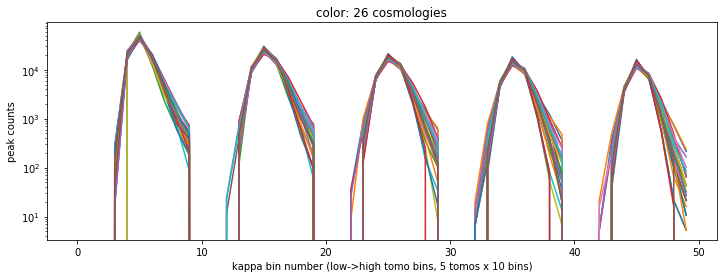

In [85]:
figure(figsize=(12,4))
for iimean in imean:
    plot(iimean)
yscale('log')
xlabel('kappa bin number (low->high tomo bins, 5 tomos x 10 bins)')
ylabel('peak counts')
title('color: 26 cosmologies')
show()

In [190]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

####### following https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py

In [209]:
idx=where(imean[-1]>0)[0]
idx=where(amin(imean,axis=0)>0)[0] ## all cosmology has nonzero counts
idx.shape

(31,)

In [230]:
std(X, axis=0)

array([0.12797955, 0.06214928, 0.42997182, 0.21836144])

In [ ]:
########## add later: do a PCA first, before interpolation may help with the accuracy

In [263]:
# Instantiate a Gaussian Process model

kernel = C(1.0, (1e-5, 1e5)) * RBF(std(X, axis=0), length_scale_bounds=(1e-2, 1e2))

# kernel =  C(1,(1e-5,1e5))*RBF(np.array([0.05,0.5,0.05]),length_scale_bounds=[[1e-2,1e2],[1e-2,1e2],[1e-2,1e2]])
#                obs_arr/=mns
# if error is not None:
#    #gp = GaussianProcessRegressor(kernel=kernel,alpha=(error/mns**2),normalize_y=True, n_restarts_optimizer=5)
#    gp = GaussianProcessRegressor(kernel=kernel,alpha=1.,normalize_y=True, n_restarts_optimizer=10)
# else:
#    gp = GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=10)
                
# parameters
X=cosmo_params[:, 1:-1]
print ('cosmo parameters shape (N_sample, N_feature):', X.shape)

# observations and noise
input_arr = stats_cosmo[:, :, 1, :, 5, :] ### peak counts, smoothing=5
kappa_arr = stats_cosmo[0, 0, 1, :, 4, :]
Y = mean(input_arr, axis=1).reshape(26,-1)[:,idx]
dY = std(input_arr, axis=1).reshape(26,-1)[:,idx]
print ('input_arr.shape:', input_arr.shape)
print ('observations shape (N_sample, N_targets):', Y.shape)
print ('noise shape (N_sample, N_targets):', dY.shape)

Ntest = 25 ## the point to be removed for testing
Xtrue, Ytrue = X[Ntest], Y[Ntest]
Xtest, Ytest, dYtest = [delete(arr, Ntest, axis=0) for arr in [X, Y, dY]]

Xtrue = expand_dims(Xtrue, axis=0)
print (Xtrue)

cosmo parameters shape (N_sample, N_feature): (26, 4)
input_arr.shape: (26, 10, 5, 10)
observations shape (N_sample, N_targets): (26, 31)
noise shape (N_sample, N_targets): (26, 31)
[[ 0.2905  0.6898 -1.      0.8364]]


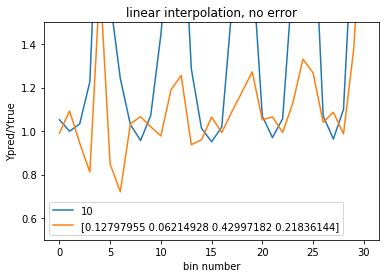

In [292]:
# idY=dYtest[:,-1] ## use the std from the last bin#fiducial model for MSE
# print (idY.shape)
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
Xstd=std(X, axis=0)
figure()
for irbf in [10, Xstd]:#, 10]:
    kernel = C(1, (1e-3, 1e3)) * RBF(irbf, length_scale_bounds=(1e-2, 1e2)) 
    #### length scale up to 10 doesn't matter much
    #### 2nd numbers (1e-5, 1e5) don't do anything
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='%s'%(irbf))
title('linear interpolation, no error')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()
show()

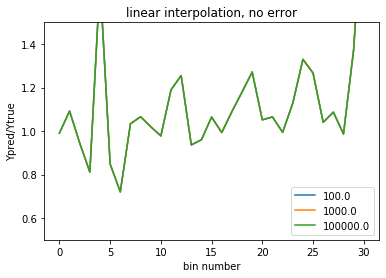

In [297]:
figure()
for Clim in [1e2, 1e3, 1e5]:
    kernel = C(1.0, (1e-3, Clim)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2)) ### length scale up to 10 doesn't matter much
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)#, alpha=idY ** 2)
    gp.fit(Xtest, Ytest)
    Ypred = gp.predict(Xtrue).ravel()
    plot(Ypred/Ytrue, label='%s'%(Clim))
title('linear interpolation, no error')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
legend()
show()

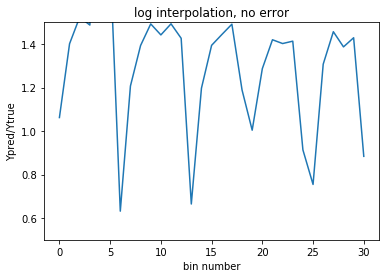

In [295]:
Ytest_log = log10(Ytest)
gp.fit(Xtest, Ytest_log)
Ypred = gp.predict(Xtrue).ravel()
plot(10**Ypred/Ytrue)
title('log interpolation, no error')
xlabel('bin number')
ylabel('Ypred/Ytrue')
ylim(0.5, 1.5)
show()

In [223]:
dYtest.shape, Ytest.shape

((25, 31), (25, 31))

31


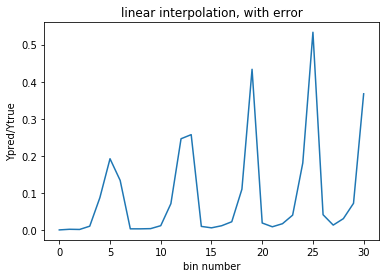

In [299]:
########### build 50 GPs, assuming no correlation between bins
kernel = C(1.0, (1e-3, 1e3)) * RBF(Xstd, length_scale_bounds=(1e-2, 1e2))
gp_arr = [GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=idY ** 2) for idY in dYtest.T]
print (len(gp_arr))
gp_run = [gp_arr[i].fit(Xtest, Ytest.T[i]) for i in arange(len(idx))]

out = [igp.predict(Xtrue, return_std=True) for igp in gp_run]
Ypred = np.array([iout[0][0] for iout in out])
Ysigma =np.array([iout[1] for iout in out])

plot(Ypred/Ytrue)
title('linear interpolation, with error')
xlabel('bin number')
ylabel('Ypred/Ytrue')
show()

In [307]:
print (dYtest.shape)
dYtest/Ytest

### next try: use covariance matrix to get the good error, not the cosmo-varying one
### PCA
### 1 tomo bin

(25, 31)


array([[0.49190903, 0.13160155, 0.32434294, 0.29706301, 0.66432412,
        1.06904497, 0.89492396, 0.33430916, 0.19181856, 0.23522982,
        0.28529472, 0.59855974, 1.21709082, 1.02862147, 0.27705507,
        0.26622444, 0.18848102, 0.35288442, 0.78409091, 0.99934875,
        0.20029349, 0.29005742, 0.16252203, 0.49587384, 0.86175449,
        1.10009437, 0.23082195, 0.29831766, 0.10624487, 0.71242902,
        0.91081545],
       [0.42675868, 0.16561661, 0.31762504, 0.59749572, 0.71070531,
        1.06207344, 1.03525806, 0.27415755, 0.27556354, 0.22391709,
        0.59761477, 0.93154575, 1.01417292, 0.8990736 , 0.21223743,
        0.30534722, 0.13516739, 0.62339517, 1.04843634, 0.92456499,
        0.18848162, 0.33659743, 0.10055818, 0.71111752, 1.03786465,
        1.06510562, 0.19902302, 0.33730474, 0.14708348, 0.81941484,
        0.99539757],
       [0.44298453, 0.05253222, 0.30430087, 0.3762205 , 0.51507875,
        1.4832397 , 1.4832397 , 0.35384708, 0.04813091, 0.22600459,
      